# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


# Install detectron2

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 1.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15517, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 15517 (delta 74), reused 188 (delta 48), pack-reused 15275
Receiving objects: 100% (15517/15517), 6.39 MiB | 13.80 MiB/s, done.
Resolving deltas: 100% (11188/11188), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 865.8 kB/s eta 0:0

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom dataset

In [4]:
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
from google.colab import drive

drive.mount('/content/drive')

# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
if "coco_training" in DatasetCatalog.list():
  DatasetCatalog.remove("coco_training")
if "coco_validation" in DatasetCatalog.list():
  DatasetCatalog.remove("coco_validation")
if "coco_test" in DatasetCatalog.list():
  DatasetCatalog.remove("coco_test")

root_path = "/content/drive/MyDrive/BigData_Project/big_data.v20i.coco/"
register_coco_instances("coco_training", {}, root_path + "train/_annotations.coco.json", root_path + "train/")
register_coco_instances("coco_validation", {}, root_path + "valid/_annotations.coco.json", root_path + "valid/")
register_coco_instances("coco_test", {}, root_path + "test/_annotations.coco.json", root_path + "test/")


Mounted at /content/drive


To verify the dataset is in correct format, let's visualize the annotations of randomly selected samples in the training set:



[03/23 15:29:10 d2.data.datasets.coco]: Loading /content/drive/MyDrive/BigData_Project/big_data.v20i.coco/train/_annotations.coco.json takes 5.26 seconds.
[03/23 15:29:10 d2.data.datasets.coco]: Loaded 951 images in COCO format from /content/drive/MyDrive/BigData_Project/big_data.v20i.coco/train/_annotations.coco.json


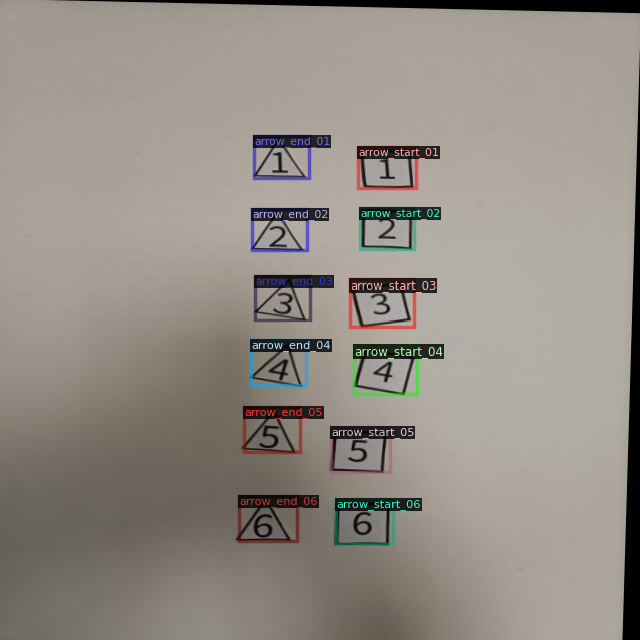

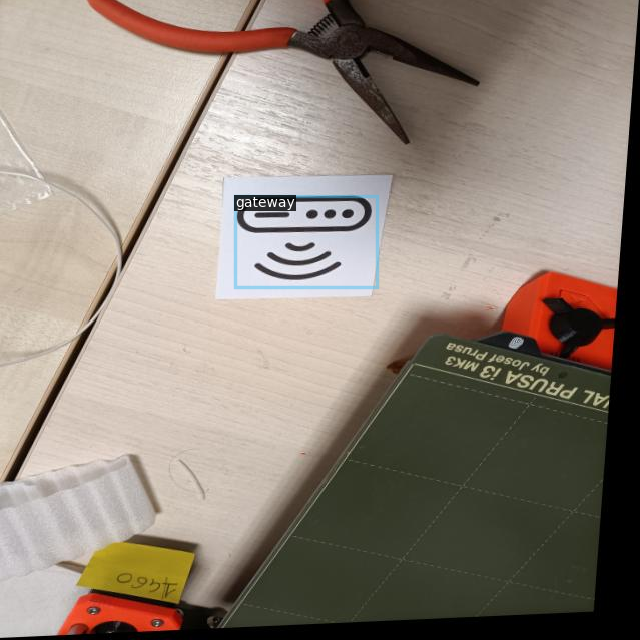

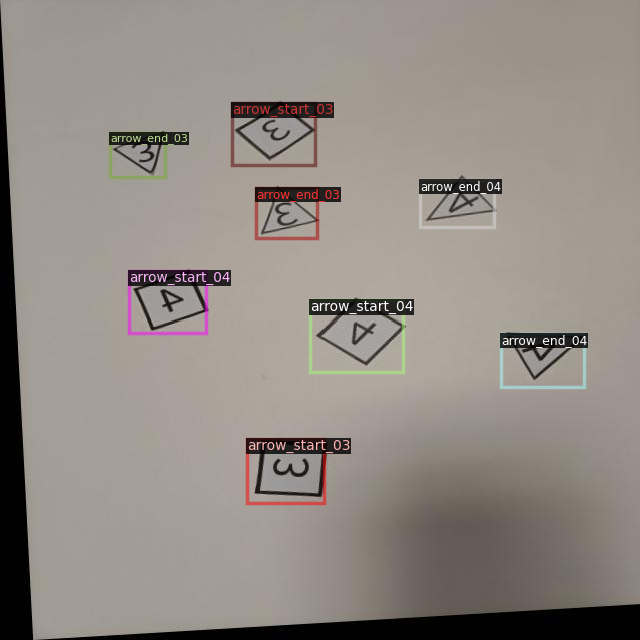

In [5]:
iot_metadata = MetadataCatalog.get("coco_training")
dataset_dicts = DatasetCatalog.get("coco_training")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=iot_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.


In [ ]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultTrainer

class Trainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name):
    os.makedirs("/content/drive/MyDrive/BigData_Project/inference", exist_ok=True)
    return COCOEvaluator(dataset_name, cfg, False, "/content/drive/MyDrive/BigData_Project/inference")

  def do_train(self):
    super().do_train()
    val_loader = build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST[0])
    evaluator = self.build_evaluator(self.cfg, self.cfg.DATASETS.TEST[0])
    inference_on_dataset(self.model, val_loader, evaluator)


In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("coco_training",)
cfg.DATASETS.TEST = ("coco_validation",) # dataset for validation phase
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/BigData_Project/output/model_final.pth" # weights of the last training
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 5  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 4000 # iterations number for the training
cfg.SOLVER.STEPS = [] # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 5 # used to sample a subset of proposals coming out of RPN to calculate cls and reg loss during training
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 16 # number of classes to recognize +1 since that with Roboflow we get the "super category" (the latter does not affect the training)
cfg.SOLVER.CHECKPOINT_PERIOD = 1000 # after how many iterations a checkpoint of the training is saved
cfg.TEST.EVAL_PERIOD = 500 # after how many iterations an evaluation phase is applied
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
os.makedirs("/content/drive/MyDrive/BigData_Project/output", exist_ok=True)
cfg.OUTPUT_DIR = "/content/drive/MyDrive/BigData_Project/output/"
trainer = Trainer(cfg) # custom Trainer with the validation phase implemented
trainer.resume_or_load(resume=False) # if the last training was interrupted before its ending set "resume" to True for restarting from the last checkpoint
trainer.train()

[03/21 08:13:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[03/21 08:13:55 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/21 08:14:16 d2.utils.events]:  eta: 0:50:59  iter: 19  total_loss: 0.2756  loss_cls: 0.0869  loss_box_reg: 0.1825  loss_rpn_cls: 0.0005863  loss_rpn_loc: 0.01568    time: 0.7665  last_time: 0.8731  data_time: 0.0623  last_data_time: 0.0249   lr: 4.9953e-06  max_mem: 3731M
[03/21 08:14:35 d2.utils.events]:  eta: 0:51:54  iter: 39  total_loss: 0.2903  loss_cls: 0.07235  loss_box_reg: 0.1519  loss_rpn_cls: 0.0009984  loss_rpn_loc: 0.01472    time: 0.7790  last_time: 0.6138  data_time: 0.0174  last_data_time: 0.0167   lr: 9.9902e-06  max_mem: 3732M
[03/21 08:14:51 d2.utils.events]:  eta: 0:52:31  iter: 59  total_loss: 0.2724  loss_cls: 0.08265  loss_box_reg: 0.1581  loss_rpn_cls: 0.0007186  loss_rpn_loc: 0.01671    time: 0.7899  last_time: 0.8107  data_time: 0.0167  last_data_time: 0.0166   lr: 1.4985e-05  max_mem: 3732M
[03/21 08:15:07 d2.utils.events]:  eta: 0:52:21  iter: 79  total_loss: 0.277  loss_cls: 0.09356  loss_box_reg: 0.1783  loss_rpn_cls: 0.0009443  loss_rpn_loc: 0.01595  

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[03/21 08:20:54 d2.evaluation.evaluator]: Inference done 11/44. Dataloading: 0.0013 s/iter. Inference: 0.0816 s/iter. Eval: 0.0003 s/iter. Total: 0.0832 s/iter. ETA=0:00:02
[03/21 08:20:57 d2.evaluation.evaluator]: Total inference time: 0:00:03.996182 (0.102466 s / iter per device, on 1 devices)
[03/21 08:20:57 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.087838 s / iter per device, on 1 devices)
[03/21 08:20:57 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/21 08:20:57 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/BigData_Project/inference/coco_instances_results.json
[03/21 08:20:58 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.5

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[03/21 08:27:50 d2.evaluation.evaluator]: Inference done 11/44. Dataloading: 0.0020 s/iter. Inference: 0.0856 s/iter. Eval: 0.0004 s/iter. Total: 0.0879 s/iter. ETA=0:00:02
[03/21 08:27:53 d2.evaluation.evaluator]: Total inference time: 0:00:03.808830 (0.097662 s / iter per device, on 1 devices)
[03/21 08:27:53 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.091684 s / iter per device, on 1 devices)
[03/21 08:27:53 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/21 08:27:53 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/BigData_Project/inference/coco_instances_results.json
[03/21 08:27:53 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.5

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[03/21 08:34:42 d2.evaluation.evaluator]: Inference done 11/44. Dataloading: 0.0014 s/iter. Inference: 0.0811 s/iter. Eval: 0.0003 s/iter. Total: 0.0828 s/iter. ETA=0:00:02
[03/21 08:34:45 d2.evaluation.evaluator]: Total inference time: 0:00:03.518056 (0.090207 s / iter per device, on 1 devices)
[03/21 08:34:45 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.084091 s / iter per device, on 1 devices)
[03/21 08:34:45 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/21 08:34:45 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/BigData_Project/inference/coco_instances_results.json
[03/21 08:34:45 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.17s).
 Average Precision  (AP) @[ IoU=0.5

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[03/21 08:41:39 d2.evaluation.evaluator]: Inference done 11/44. Dataloading: 0.0090 s/iter. Inference: 0.0872 s/iter. Eval: 0.0003 s/iter. Total: 0.0966 s/iter. ETA=0:00:03
[03/21 08:41:42 d2.evaluation.evaluator]: Total inference time: 0:00:03.541276 (0.090802 s / iter per device, on 1 devices)
[03/21 08:41:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.083771 s / iter per device, on 1 devices)
[03/21 08:41:42 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/21 08:41:42 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/BigData_Project/inference/coco_instances_results.json
[03/21 08:41:42 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.5

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[03/21 08:48:30 d2.evaluation.evaluator]: Inference done 11/44. Dataloading: 0.0013 s/iter. Inference: 0.0816 s/iter. Eval: 0.0003 s/iter. Total: 0.0832 s/iter. ETA=0:00:02
[03/21 08:48:33 d2.evaluation.evaluator]: Total inference time: 0:00:03.613895 (0.092664 s / iter per device, on 1 devices)
[03/21 08:48:33 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.084839 s / iter per device, on 1 devices)
[03/21 08:48:33 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/21 08:48:33 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/BigData_Project/inference/coco_instances_results.json
[03/21 08:48:33 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.19s).
 Average Precision  (AP) @[ IoU=0.5

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[03/21 08:55:27 d2.evaluation.evaluator]: Inference done 11/44. Dataloading: 0.0023 s/iter. Inference: 0.0877 s/iter. Eval: 0.0003 s/iter. Total: 0.0903 s/iter. ETA=0:00:02
[03/21 08:55:30 d2.evaluation.evaluator]: Total inference time: 0:00:03.501016 (0.089770 s / iter per device, on 1 devices)
[03/21 08:55:30 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.085279 s / iter per device, on 1 devices)
[03/21 08:55:30 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/21 08:55:30 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/BigData_Project/inference/coco_instances_results.json
[03/21 08:55:30 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.10s).
 Average Precision  (AP) @[ IoU=0.5

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[03/21 09:02:22 d2.evaluation.evaluator]: Inference done 11/44. Dataloading: 0.0107 s/iter. Inference: 0.0826 s/iter. Eval: 0.0003 s/iter. Total: 0.0936 s/iter. ETA=0:00:03
[03/21 09:02:25 d2.evaluation.evaluator]: Total inference time: 0:00:03.560260 (0.091289 s / iter per device, on 1 devices)
[03/21 09:02:25 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.083156 s / iter per device, on 1 devices)
[03/21 09:02:25 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/21 09:02:25 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/BigData_Project/inference/coco_instances_results.json
[03/21 09:02:25 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.5

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[03/21 09:09:20 d2.evaluation.evaluator]: Inference done 11/44. Dataloading: 0.0013 s/iter. Inference: 0.0813 s/iter. Eval: 0.0003 s/iter. Total: 0.0829 s/iter. ETA=0:00:02
[03/21 09:09:23 d2.evaluation.evaluator]: Total inference time: 0:00:03.324765 (0.085250 s / iter per device, on 1 devices)
[03/21 09:09:23 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.081262 s / iter per device, on 1 devices)
[03/21 09:09:23 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/21 09:09:23 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/BigData_Project/inference/coco_instances_results.json
[03/21 09:09:23 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.5

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [6]:
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 16 # number of classes to recognize +1 since that with Roboflow we get the "super category" (the latter does not affect the training)
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/BigData_Project/output/model_final.pth"  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[03/23 15:29:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/BigData_Project/output/model_final.pth ...


Then, we randomly select several samples to visualize the prediction results.

In [7]:
from detectron2.utils.visualizer import ColorMode

validation_metadata = MetadataCatalog.get("coco_validation")

for d in os.listdir(root_path + "/test"):
  if ".json" not in d:
    im = cv2.imread(root_path + "/test/" + d)
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                    metadata=validation_metadata,
                    scale=0.5,
                    instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.